# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [98]:
# Python 3.6 or above is required
import io
import os

from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path

import urllib.request

In [99]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [100]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        if word in self.words:
            return self.embeddings[self.word2id[word]]
        else:
            return np.zeros(self.embeddings.shape[1])
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        if word1 in self.words:
            emb1 = self.embeddings[self.word2id[word1]]
        if word2 in self.words:
            emb2 = self.embeddings[self.word2id[word2]]
        if (word1 in self.words) and( word2 in self.words):
            return emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
        else:
            return 0
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        list_score = [self.score(word, w) for w in self.words]
        if max(list_score)>0:
            index_best_words = (np.argsort(list_score)[::-1][:k])
            return list(np.array(self.words)[index_best_words])
        else:
            print('WARNING : The word proposed is not in the vocabulary')
            return []

In [101]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'pup', 'canine']
['dogs', 'dog', 'cats', 'puppies', 'Dogs']
['Paris', 'France', 'Parisian', 'Marseille', 'Brussels']
['Germany', 'Austria', 'Europe', 'Berlin', 'Hamburg']


In [102]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        idf = {}
        for sent in sentences:
            for w in sent.split(' '):
                idf[w] = idf.get(w, 0) + 1        
        for w in idf:
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
        return idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        sentemb = []
        for sent in sentence:
            embed = []
            words = sent.split(' ')
            if idf is None:
                # mean of word vectors
                for _, word in enumerate(words):
                    if word in self.word2vec.words:
                        embed.append(self.word2vec.encode(word))
                    
                if len(embed) == 0:
                    embed = np.zeros((1, 300))
                else:
                    embed = np.vstack(embed)
                sentemb.append(np.mean(embed, axis=0))
            else:
                # idf-weighted mean of word vectors
                for _, word in enumerate(words):
                    if word in self.word2vec.words and word in idf.keys():
                        embed.append(self.word2vec.encode(word) * idf[word])
                    
                if len(embed) == 0:
                    embed = np.zeros((1, 300))
                else:
                    embed = np.vstack(embed)
                sentemb.append(np.mean(embed, axis=0))
        return np.vstack(sentemb)

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        emb2 = self.encode([sentence2], idf)
        emb1 = self.encode([sentence1], idf)
        if ((np.linalg.norm(emb1)!=0) and ((np.linalg.norm(emb2)!=0))):
            return emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
        else: 
            return 0
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        similarities = np.zeros(len(sentences))
        for i in range(similarities.shape[0]):
            similarities[i] = self.score(sentence, sentences[i], idf)
        index_best_sentences = (np.argsort(similarities)[::-1][:k])
        res = []
        for index in index_best_sentences:
            res.append(sentences[index])
        return res

In [103]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
[[0.70652206]]
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) a small boy following 4 geese . 
5) 2 female babies eating chips . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
[[0.70379268]]
2 female babies eating chips . 
1) 2 female babies eating chips . 
2) 2 kids holding hands and smiling . 
3) 3 men , 2 shoveling dirt and the other laying down cement . 
4) 3 little kids are playing football . 
5) two men and 2 women running . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [104]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        en_keys = list(self.en_word2vec.words)
        fr_keys = list(self.fr_word2vec.words)

        common_keys = list(set(en_keys) & set(fr_keys))

        X = np.array([self.fr_word2vec.encode(key) for key in common_keys]).T
        Y = np.array([self.en_word2vec.encode(key) for key in common_keys]).T
        
        M = Y@(X.T)
        U,S,V = np.linalg.svd(M)
        W = U@V #W is of shape (300,300)
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        return np.matmul(fr_word2vec.embeddings, W.transpose())

        
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        emb1 = self.aligned_fr_embeddings[self.fr_word2vec.word2id[fr_word]]
        keys = self.en_word2vec.embeddings
        list_scores = np.zeros(keys.shape[0])
        list_idx = np.empty(keys.shape[0])
        score = 0
        for i in range(keys.shape[0]):
            emb2 = keys[i]
            list_scores[i] = emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
        index_best_words = (np.argsort(list_scores)[::-1][:k])
        res = np.array(self.en_word2vec.words)[index_best_words]
        return res

In [105]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [106]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

# TYPE CODE HERE
def load_sentences(filepath, get_labels=True):
    sentences = []
    labels = []
    f = open(os.path.join(filepath), "r")
    if get_labels:
        for line in f:
            sentences.append(line.split('\n')[0][2:])
            labels.append(int(line.split('\n')[0][0]))
        return sentences, np.array(labels)
    else:
        for line in f:
            sentences.append(line.split('\n')[0][2:])
        return sentences

train, y_train = load_sentences(train_filepath)
dev, y_dev = load_sentences(dev_filepath)
test = load_sentences(test_filepath, get_labels=False)

In [107]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

X_train = sentence2vec.encode(train)
X_dev = sentence2vec.encode(dev)

idf = sentence2vec.build_idf(train + dev)
X_train_idf = sentence2vec.encode(train, idf=idf)
X_dev_idf = sentence2vec.encode(dev, idf=idf)

Loaded 50000 pretrained word vectors


The best value of C for 'Average of word vectors' is 10.00 with a score of 0.467 for train and 0.415 for dev
The best value of C for 'Weighted average of word vectors' is 1.00 with a score of 0.464 for train and 0.423 for dev


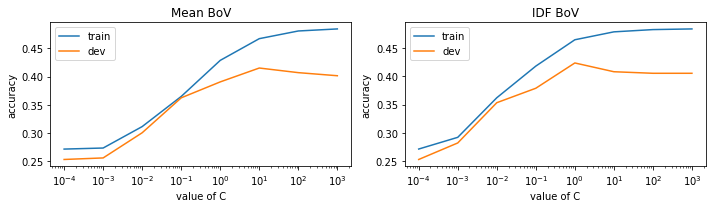

In [108]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

penalisations = 10.0**np.arange(-4,4)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

train_acc, dev_acc = [], []
for pen in penalisations:
    lr = LogisticRegression(C = pen, penalty = 'l2', multi_class='multinomial', solver='newton-cg')
    lr.fit(X_train, y_train)
    prediction_dev = lr.predict(X_dev)
    prediction_train = lr.predict(X_train)
    train_acc.append(accuracy_score(y_train, prediction_train))
    dev_acc.append(accuracy_score(y_dev, prediction_dev))

print("The best value of C for 'Average of word vectors' is %.2f with a score of %.3f for train and %.3f for dev"%(penalisations[np.argmax(dev_acc)], train_acc[np.argmax(dev_acc)], max(dev_acc)))
    
ax[0].plot(penalisations, train_acc, label='train')
ax[0].plot(penalisations, dev_acc, label='dev')
ax[0].set_title('Mean BoV')
ax[0].set_xscale('log')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('value of C')
ax[0].legend()
    

train_acc, dev_acc = [], []
for pen in penalisations:
    lr_idf = LogisticRegression(C = pen, multi_class='multinomial', solver='newton-cg')
    lr_idf.fit(X_train_idf, y_train)
    train_acc.append(lr_idf.score(X_train_idf, y_train))
    dev_acc.append(lr_idf.score(X_dev_idf, y_dev))
    
print("The best value of C for 'Weighted average of word vectors' is %.2f with a score of %.3f for train and %.3f for dev"%(penalisations[np.argmax(dev_acc)], train_acc[np.argmax(dev_acc)], max(dev_acc)))

ax[1].plot(penalisations, train_acc, label='train')
ax[1].plot(penalisations, dev_acc, label='dev')
ax[1].set_title('IDF BoV')
ax[1].set_xscale('log')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('value of C')
ax[1].legend()

fig.tight_layout()
fig.savefig('logistic_regression_penalization.png')

In [109]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
model = LogisticRegression(C=15.00) # a further study show that we get better results with 15 rather than 10
#we train it on all of the data available
model.fit(np.vstack((X_train, X_dev)), np.concatenate((y_train, y_dev)))
y_test = model.predict(X_test)

np.savetxt(os.path.join(PATH_TO_DATA, 'logreg_bow_y_test_sst.txt'), y_test, fmt='%d')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [110]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, max_features=30, max_depth=5)
rf_classifier.fit(X_train, y_train) 
prediction_dev_rf = rf_classifier.predict(X_dev)
prediction_train_rf = rf_classifier.predict(X_train)


rf_classifier_idf = RandomForestClassifier(n_estimators=100, max_features=30, max_depth=5)
rf_classifier_idf.fit(X_train_idf, y_train) 
prediction_dev_rf_idf = rf_classifier_idf.predict(X_dev_idf)
prediction_train_rf_idf = rf_classifier_idf.predict(X_train_idf)


print('Random Forest Precision on train set', accuracy_score(y_train,prediction_train_rf))
print('Random Forest Precision on dev set', accuracy_score(y_dev,prediction_dev_rf))

print('Random Forest Precision on train set idf', accuracy_score(y_train,prediction_train_rf_idf))
print('Random Forest Precision on dev set idf', accuracy_score(y_dev,prediction_dev_rf_idf))

model = RandomForestClassifier(n_estimators=100, max_features=30, max_depth=5)
#we train it on all of the data available
model.fit(np.vstack((X_train, X_dev)), np.concatenate((y_train, y_dev)))
y_test = model.predict(X_test)

np.savetxt(os.path.join(PATH_TO_DATA, 'randforest_bow_y_test_sst.txt'), y_test, fmt='%d')

Random Forest Precision on train set 0.40402621722846443
Random Forest Precision on dev set 0.3442325158946412
Random Forest Precision on train set idf 0.4133895131086142
Random Forest Precision on dev set idf 0.3405994550408719


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [111]:
import keras

In [112]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing import text
from keras.utils import to_categorical

all_sentences = train + dev + test

vocabulary = set([w for sent in all_sentences for w in sent.split()])
MAX_SENT   = np.max([len(sent.split(' ')) for sent in all_sentences])
VOCAB_SIZE = len(vocabulary)

x_train_oneh = [text.one_hot(elem,VOCAB_SIZE) for elem in train]
x_dev_oneh   = [text.one_hot(elem,VOCAB_SIZE) for elem in dev]
x_test_oneh  = [text.one_hot(elem,VOCAB_SIZE) for elem in test]

y_train = to_categorical(y_train)
y_val = to_categorical(y_dev)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [113]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences

x_train_pad = pad_sequences(x_train_oneh, maxlen=MAX_SENT)
x_val_pad = pad_sequences(x_dev_oneh, maxlen=MAX_SENT)
x_test_pad = pad_sequences(x_test_oneh, maxlen=MAX_SENT)

## 4.2 - Design and train your model

In [114]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

In [115]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          1600000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 1,625,157
Trainable params: 1,625,157
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 16s 2ms/sample - loss: 1.5761 - acc: 0.2721 - val_loss: 1.5727 - val_acc: 0.2534
Epoch 2/5
8544/8544 [==============================] - 13s 1ms/sample - loss: 1.5373 - acc: 0.3078 - val_loss: 1.5003 - val_acc: 0.3306
Epoch 3/5
8544/8544 [==============================] - 13s 2ms/sample - loss: 1.4116 - acc: 0.3826 - val_loss: 1.4508 - val_acc: 0.3533
Epoch 4/5
8544/8544 [==============================] - 13s 2ms/sample - loss: 1.2837 - acc: 0.4252 - val_loss: 1.4005 - val_acc: 0.3688
Epoch 5/5
8544/8544 [==============================] - 13s 2ms/sample - loss: 1.1890 - acc: 0.4521 - val_loss: 1.4334 - val_acc: 0.3706
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


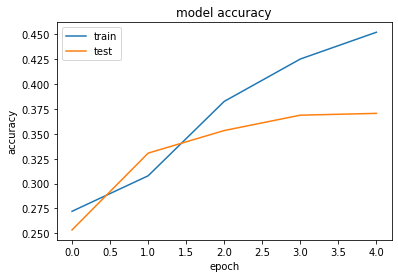

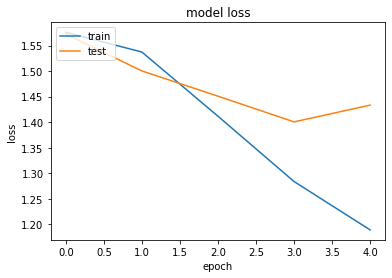

In [116]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 64
n_epochs = 5

history = model.fit(x_train_pad, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val_pad, y_val))

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_1_accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_1_loss.png')
plt.show()


In [117]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
y_test = np.argmax(model.predict(x_test_pad), axis=1)
np.savetxt(os.path.join(PATH_TO_DATA, 'logreg_lstm_y_test_sst.txt'), y_test, fmt= '%d')

## 4.3 - innovate !

Loaded 50000 pretrained word vectors


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.3, recurrent_dropout=0.3)`


Train on 8544 samples, validate on 1101 samples
Epoch 1/25
8544/8544 [==============================] - 17s 2ms/step - loss: 1.5573 - accuracy: 0.2913 - val_loss: 1.4981 - val_accuracy: 0.3388
Epoch 2/25
8544/8544 [==============================] - 13s 2ms/step - loss: 1.4789 - accuracy: 0.3443 - val_loss: 1.4288 - val_accuracy: 0.3697
Epoch 3/25
8544/8544 [==============================] - 13s 2ms/step - loss: 1.4226 - accuracy: 0.3691 - val_loss: 1.3807 - val_accuracy: 0.3760
Epoch 4/25
8544/8544 [==============================] - 13s 2ms/step - loss: 1.3878 - accuracy: 0.3763 - val_loss: 1.3518 - val_accuracy: 0.3878
Epoch 5/25
8544/8544 [==============================] - 14s 2ms/step - loss: 1.3634 - accuracy: 0.3894 - val_loss: 1.3410 - val_accuracy: 0.3978
Epoch 6/25
8544/8544 [==============================] - 13s 2ms/step - loss: 1.3469 - accuracy: 0.4038 - val_loss: 1.3856 - val_accuracy: 0.3969
Epoch 7/25
8544/8544 [==============================] - 13s 2ms/step - loss: 1.322

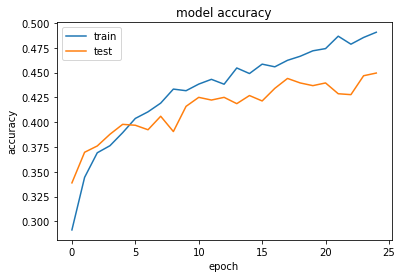

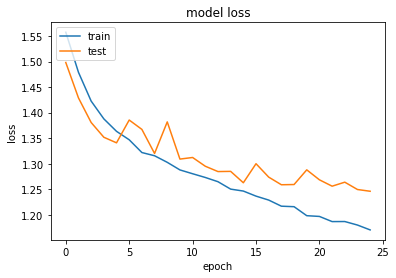

In [123]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dense, Activation, Bidirectional, Flatten, Dropout


w2v = Word2Vec(en_embeddings_path, vocab_size=50000)

train, y_train = load_sentences(train_filepath)
dev, y_dev = load_sentences(dev_filepath)
test = load_sentences(test_filepath, get_labels=False)


## Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)
word_index = tokenizer.word_index
index_to_word = dict((v,k) for k,v in word_index.items())
vocab_size=len(word_index)+1

## One hot encoding
sequences_train = tokenizer.texts_to_sequences(train)
sequences_dev = tokenizer.texts_to_sequences(dev)
sequences_test= tokenizer.texts_to_sequences(test)

X_dev_pad_2 = pad_sequences(sequences_dev, maxlen=40)
X_train_pad_2= pad_sequences(sequences_train, maxlen=40)
X_test_pad_2= pad_sequences(sequences_test, maxlen=40)

y_train_ones=to_categorical(y_train)
y_dev_ones=to_categorical(y_dev)

## Matrix with pretrained embeddings
embedding_matrix = np.zeros((vocab_size,300))
for word, i in word_index.items():
    embedding_vector = w2v.encode(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

        
        

## New model
embed_dim  = 300 # word embedding dimension
nhid       = 64 # number of hidden units in the LSTM
vocab_size = len(word_index)+1 # size of the vocabulary
n_classes  = 5
n_reduction=150

model_2 = Sequential()
model_2.add(Embedding(vocab_size,embed_dim,weights=[embedding_matrix],
                            input_length=40,trainable=False))
model_2.add(Dropout(0.3))
model_2.add(Dense(n_reduction,activation="relu"))
model_2.add(Bidirectional(LSTM(nhid, dropout_W=0.3, dropout_U=0.3)))
model_2.add(Dense(n_classes, activation='sigmoid'))



loss_classif     =  'categorical_crossentropy' 
optimizer        =  'rmsprop' 
metrics_classif  =  ['accuracy']

model_2.compile(loss=loss_classif, optimizer=optimizer, metrics=metrics_classif)

bs = 64
n_epochs = 25

history = model_2.fit(X_train_pad_2, y_train_ones, batch_size=bs, epochs=n_epochs, validation_data=(X_dev_pad_2, y_dev_ones))



print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_2_accuracy.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_2_loss.png')
plt.show()



y_test = np.argmax(model_2.predict(X_test_pad_2), axis=1)
np.savetxt(os.path.join(PATH_TO_DATA, 'pretrainembedding_lstm_y_test_sst.txt'), y_test, fmt= '%d')